# Build a Neural Style Transfer with PyTorch

![NTS](static/NTS.png "NTS")

# Importing Modules

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

# Using CUDA

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the images

In [5]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("images/apple.jpg")
content_img = image_loader("images/fig.jpg")

assert style_img.size() == content_img.size(), \
    "You have to import style and content images of the same size"

# Displaying the images

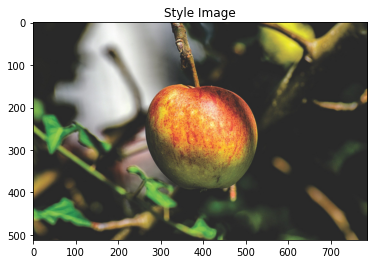

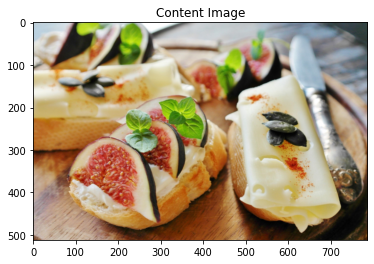

In [6]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None, axis=True):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    if not axis: plt.axis("off")
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


# The content loss function

In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# The style loss function

In [8]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Loading the neural network

In [10]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [11]:
print(cnn)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [12]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [13]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/style losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

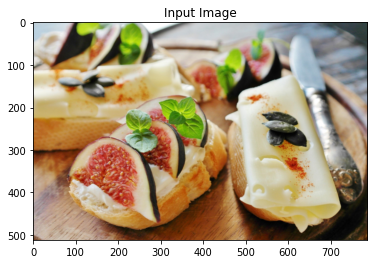

In [14]:
input_image = content_img.clone()
plt.figure()
imshow(input_image, title='Input Image')

# Gradient Descent

In [15]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# Training loop function

In [18]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):

    style_losses_l=[]
    content_losses_l=[]

    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)

            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            style_losses_l.append(style_score.item())
            content_losses_l.append(content_score.item())

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run}:")
                print(f'Style Loss : {style_score.item():4f} || Content Loss: {content_score.item():4f}\n')
                temp=input_img
                plt.figure()
                imshow(temp, title=f'Output Image After {run[0]} Iterations')
                plt.ioff()
                plt.show()
                print()

            return style_score + content_score

        optimizer.step(closure)


    input_img.data.clamp_(0, 1)

    return input_img, style_losses_l, content_losses_l

# Model Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss : 26.019556 || Content Loss: 5.502223



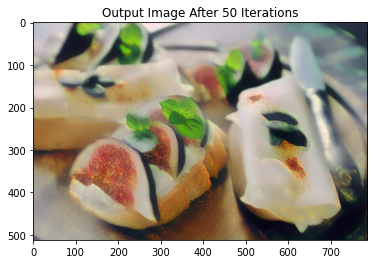


run [100]:
Style Loss : 15.895263 || Content Loss: 5.764300



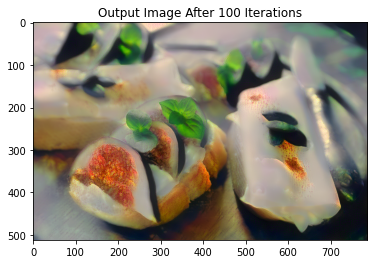


run [150]:
Style Loss : 10.033608 || Content Loss: 5.651991



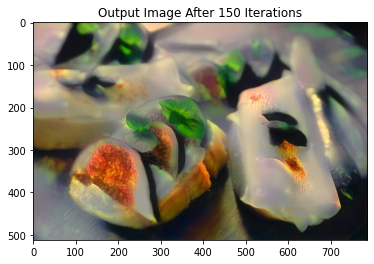


run [200]:
Style Loss : 6.171363 || Content Loss: 5.483542



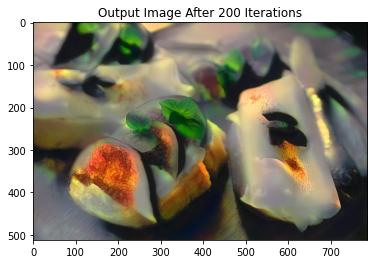


run [250]:
Style Loss : 3.837984 || Content Loss: 5.322423



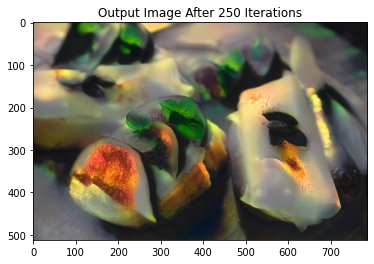


run [300]:
Style Loss : 2.515288 || Content Loss: 5.095125



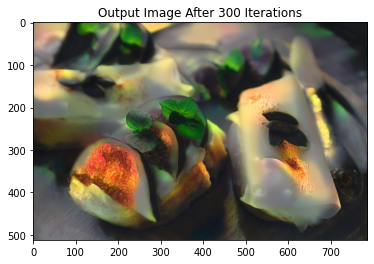


run [350]:
Style Loss : 1.866137 || Content Loss: 4.867895



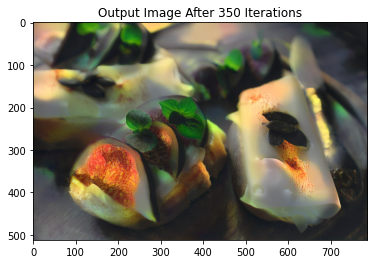


run [400]:
Style Loss : 1.490237 || Content Loss: 4.692978



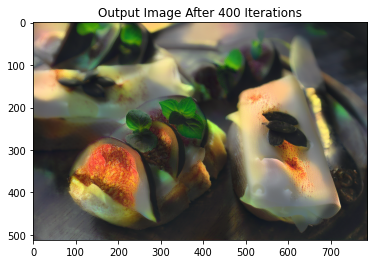


run [450]:
Style Loss : 1.263025 || Content Loss: 4.556454



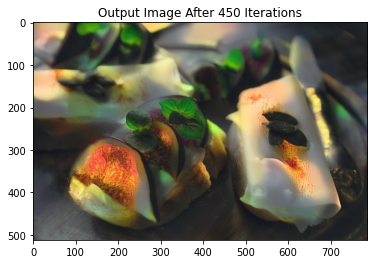


run [500]:
Style Loss : 1.110256 || Content Loss: 4.447873



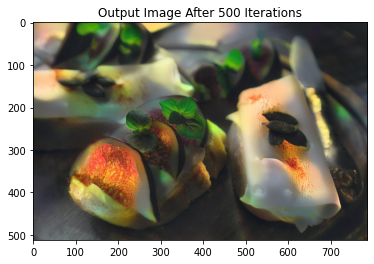


run [550]:
Style Loss : 0.987897 || Content Loss: 4.363058



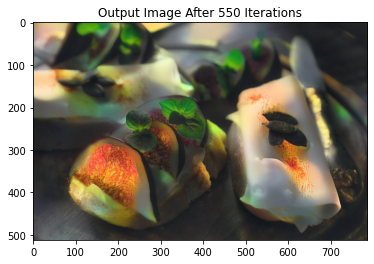


run [600]:
Style Loss : 0.880588 || Content Loss: 4.299425



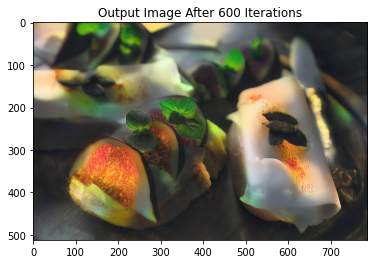


run [650]:
Style Loss : 0.790731 || Content Loss: 4.244146



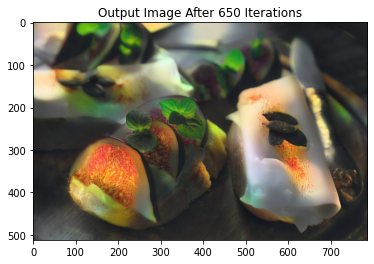


run [700]:
Style Loss : 0.721468 || Content Loss: 4.202320



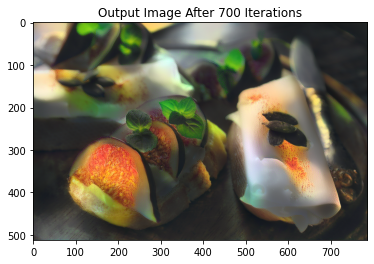


run [750]:
Style Loss : 0.673216 || Content Loss: 4.160475



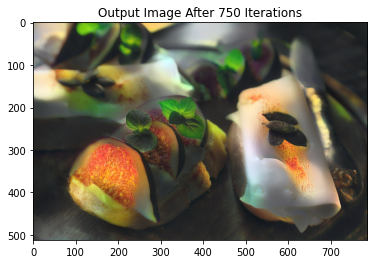


run [800]:
Style Loss : 0.644171 || Content Loss: 4.123067



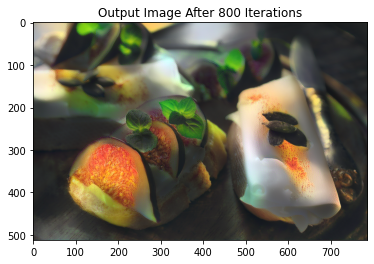

In [19]:
output, style_losses_li, content_losses_li = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_image, num_steps=800)


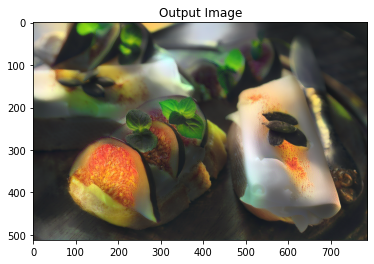

In [20]:
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

# Model Evaluation

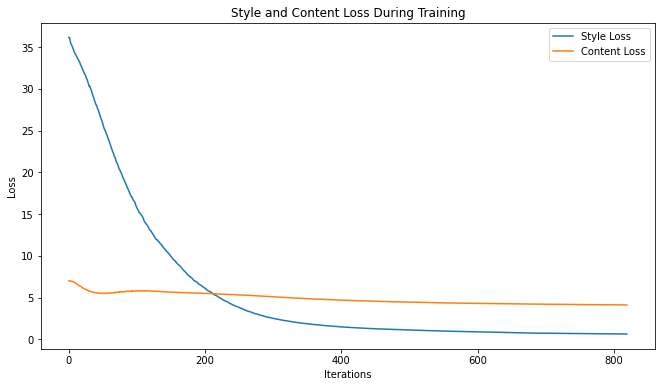

In [21]:
plt.figure(figsize=(11,6))
plt.title("Style and Content Loss During Training")
plt.plot(style_losses_li,label="Style Loss")
plt.plot(content_losses_li,label="Content Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(), 
plt.show()

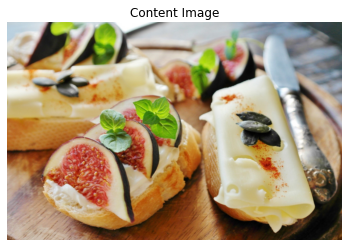

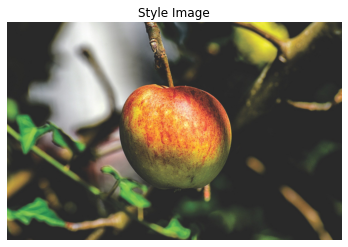

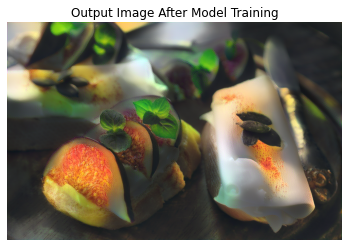

In [22]:
titles = ["Content Image", "Style Image", "Output Image After Model Training"]
for i, j in zip([content_img, style_img, output], titles):
  plt.figure()
  imshow(i, title=j, axis=False)
  plt.ioff()
  plt.show()